In [95]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

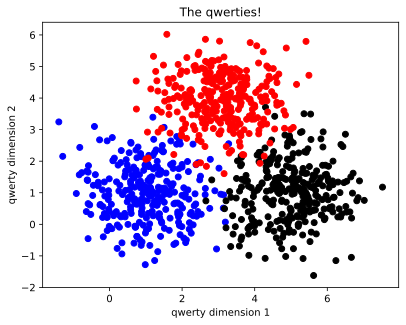

In [96]:
# create data

nPerClust = 300
blur = 0.9

A = [1, 1]
B = [5, 1]
C = [3, 4]

# generate data
a = [A[0] + np.random.randn(nPerClust) * blur, A[1] + np.random.randn(nPerClust) * blur]
b = [B[0] + np.random.randn(nPerClust) * blur, B[1] + np.random.randn(nPerClust) * blur]
c = [C[0] + np.random.randn(nPerClust) * blur, C[1] + np.random.randn(nPerClust) * blur]

# true labels
labels_np = np.hstack(
    (np.zeros((nPerClust)), np.ones((nPerClust)), 1 + np.ones((nPerClust)))
)

# concatanate into a matrix
data_np = np.hstack((a, b, c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()  # note: "long" format for CCE

# show the data
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], "bo")
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], "ko")
plt.plot(data[np.where(labels == 2)[0], 0], data[np.where(labels == 2)[0], 1], "ro")
plt.title("The qwerties!")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()

In [97]:
# split the data
train_data, devtest_data, train_labels, devtest_labels = train_test_split(
    data, labels, train_size=0.7
)

# now split the devtest data
dev_data, test_data, dev_labels, test_labels = train_test_split(
    devtest_data, devtest_labels, train_size=0.5
)

# print out the sizes
print("   Total data size: " + str(data.shape) + "\n")
print("Training data size: " + str(train_data.shape))
print("  Devset data size: " + str(dev_data.shape))
print("    Test data size: " + str(test_data.shape))

   Total data size: torch.Size([900, 2])

Training data size: torch.Size([630, 2])
  Devset data size: torch.Size([135, 2])
    Test data size: torch.Size([135, 2])


In [98]:
# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
dev_data   = TensorDataset(dev_data,dev_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 30
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(dev_data,batch_size=dev_data.tensors[0].shape[0])
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [99]:
# create a class for the model
def createTheQwertyNet():

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(2, 8)
            self.fc1 = nn.Linear(8, 8)
            self.output = nn.Linear(8, 3)

        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)

    net = qwertyNet()
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    return net, lossfun, optimizer

In [100]:
def function2trainTheModel():

    theBestModel = {"Accuracy": 0, "net": None, "epoch": 0}
    numepochs = 100

    # create a new model
    net, lossfun, optimizer = createTheQwertyNet()

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    devAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # switch on training mode
        net.train()

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            batchAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X, y = next(iter(dev_loader))  # extract X,y from devset dataloader
        with torch.no_grad():  # deactivates autograd
            yHat = net(X)

        devAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))

        # New! Store this model if it's the best so far
        if devAcc[-1] > theBestModel["Accuracy"]:
            theBestModel["Accuracy"] = devAcc[-1].item()
            theBestModel["net"] = copy.deepcopy(net.state_dict())
            theBestModel["epoch"] = epochi

    # function output
    return trainAcc, devAcc, losses, theBestModel

In [101]:
# run the model
trainAcc, devAcc, losses, theBestModel = function2trainTheModel()

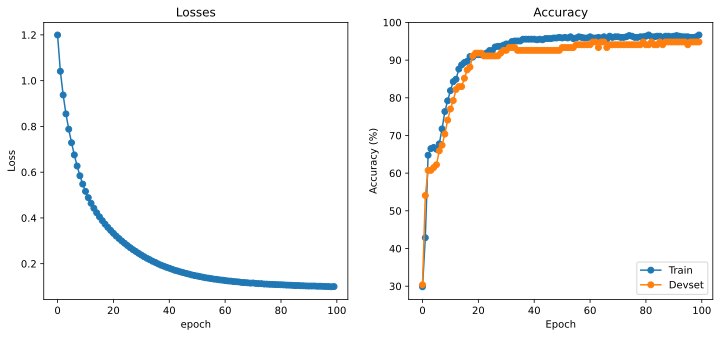

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(losses.detach(), "o-")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("epoch")
ax[0].set_title("Losses")

ax[1].plot(trainAcc, "o-", label="Train")
ax[1].plot(devAcc, "o-", label="Devset")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Accuracy")
ax[1].legend()
plt.show()

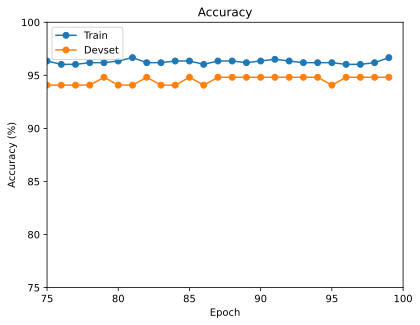

In [103]:
plt.plot(trainAcc, "o-", label="Train")
plt.plot(devAcc, "o-", label="Devset")
plt.ylabel("Accuracy (%)")
plt.xlabel("Epoch")
plt.title("Accuracy")
plt.xlim([75, 100])
plt.ylim([75, 100])
plt.legend()
plt.show()

In [104]:
print("The best model was at epoch " + str(theBestModel["epoch"]) + " with accuracy " + str(theBestModel["Accuracy"]))

The best model was at epoch 61 with accuracy 94.81481170654297


In [105]:
# recreate the best-performing model
bestnet = createTheQwertyNet()[0]
bestnet.load_state_dict(theBestModel["net"])

<All keys matched successfully>

In [106]:
# and run the data through TEST
X,y = next(iter(test_loader)) 
yHat = bestnet(X)

bestAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
bestAcc

tensor(97.0370)

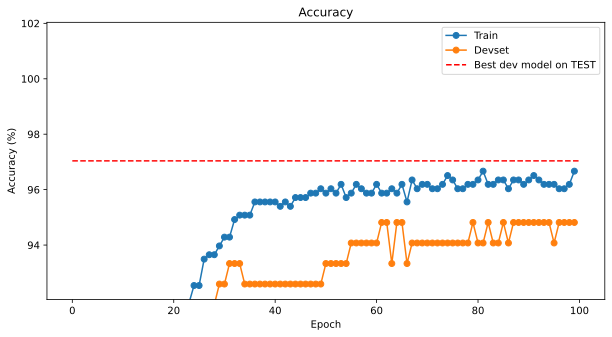

In [107]:
fig = plt.figure(figsize=(10, 5))

plt.plot(trainAcc, "o-", label="Train")
plt.plot(devAcc, "o-", label="Devset")
plt.plot([0, len(devAcc)], [bestAcc, bestAcc], "r--", label="Best dev model on TEST")
plt.ylabel("Accuracy (%)")
plt.xlabel("Epoch")
plt.title("Accuracy")
plt.ylim([bestAcc - 5, bestAcc + 5])
plt.legend()
plt.show()

In [108]:
# model perfomed very well on the test data, even crossing the train accuracy.
# here there is no overfitting, model actually learned.